In [76]:
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
import os

load_dotenv()
def set_env_vars(var):
    os.environ[var] = os.getenv(var)


vars = ["OPENAI_API_KEY", "LANGCHAIN_API_KEY", "LANGCHAIN_TRACING_V2", "LANGCHAIN_ENDPOINT", "LANGCHAIN_PROJECT", "TAVILY_API_KEY"]

for var in vars:
    set_env_vars(var)

llm = ChatOpenAI(model="gpt-4o", temperature=0)

In [77]:
import nest_asyncio
nest_asyncio.apply()

In [117]:
from pydantic import BaseModel
from playwright.async_api import Page
from langgraph.graph import MessagesState
from typing import Literal, List


class Bbox(BaseModel):
    id: int
    x: float
    y: float
    type: str
    text: str
    arialabel: str

class ImageScreenShoot(BaseModel):
    img : str
    bboxes : List[Bbox]

class Action(BaseModel):
    action: Literal["click_element", "scroll_element", "type_text", "wait", "go_back", "go_to_google", "ANSWER"]
    text_to_type: str
    bbox: Bbox

class AnswerNode(BaseModel):
    answer: str

class PlanState(BaseModel):
    plan: List[str]

class AgentState(MessagesState):
    task: str
    page: Page
    master_plan: PlanState
    current_plan: PlanState
    screenshot: ImageScreenShoot
    tool_and_bbox_action: Action
    last_tool_action: str
    answer: AnswerNode
    status: Literal["in_progress", "completed"]


In [111]:
import base64
import asyncio
from playwright.async_api import async_playwright
import asyncio
from PIL import Image as PILImage
import io


with open("mark_page.js") as f:
    mark_page_script = f.read()


async def mark_page(page):
    await page.evaluate(mark_page_script)
    for _ in range (10):
        try: 
            bboxes = await page.evaluate("markPage()")
            break
        except Exception:
            asyncio.sleep(3)
    # Get screenshot as bytes
    screenshot_bytes = await page.screenshot(path="screenshot.png")
    
    # Convert to PIL Image
    img = PILImage.open(io.BytesIO(screenshot_bytes))
    # Convert to grayscale to reduce color information
    img = img.convert('L')
    
    # Resize image (adjust dimensions as needed)
    max_size = (300, 300)  # You can adjust these dimensions
    img.thumbnail(max_size, PILImage.Resampling.LANCZOS)
    
    # Quantize the image to reduce number of colors
    img = img.quantize(colors=16)  # Reduce to 16 colors
    img = img.convert('L')  # Convert back to grayscale before JPEG saving

    # Save with compression
    buffer = io.BytesIO()
    img.save(buffer, format='JPEG', quality=5,  # Reduced quality
                optimize=True,  # Enable additional optimization
                progressive=True)  # Use progressive encoding
    compressed_bytes = buffer.getvalue()
    await page.evaluate("unmarkPage()")
    return ImageScreenShoot(img = base64.b64encode(compressed_bytes).decode("utf-8"), bboxes=bboxes)



In [112]:
from langchain_core.tools import Tool
from langchain_core.tools import StructuredTool
from langchain_core.messages import AIMessage, HumanMessage
import platform

async def click_element(agent_state: AgentState):
    """Click on a specified element on the webpage using its bounding box coordinates.
    
    Args:
        agent_state (AgentState): The current state of the agent containing page and action information
        
    """
    print("********************CLICK ELEMENT TOOL********************\n")
    print("----------------------------------------------------------\n")
    print(f"Agent State: {agent_state}")
    print("----------------------------------------------------------\n")
    page = agent_state["page"]
    print(f"Page: {page}")
    print("----------------------------------------------------------\n")
    tool_and_bbox_action = agent_state["tool_and_bbox_action"]
    print(f"Tool and Bbox Action: {tool_and_bbox_action}")
    print("----------------------------------------------------------\n")
    bbox = tool_and_bbox_action["bbox"]
    print(f"Bbox: {bbox}")
    print("----------------------------------------------------------\n")
    await page.mouse.click(bbox["x"], bbox["y"])
    sleep_time = 2
    await asyncio.sleep(sleep_time)
    bbox_text = bbox["text"]
    bbox_id = bbox["id"]
    return {"messages": [AIMessage(content=f"clicked element with id {bbox_id} and text {bbox_text}")], "last_tool_action": f"click_element with id {bbox_id} and text {bbox_text}"} # Return string, not dict

async def scroll_element(agent_state: AgentState):
    """Scroll the webpage up or down.
    
    Args:
        agent_state (AgentState): The current state of the agent containing page and action information
        
   
    """
    print("********************SCROLL TOOL********************\n")
    print("----------------------------------------------------------\n")
    print(f"Agent State: {agent_state}")
    print("----------------------------------------------------------\n")
    page = agent_state["page"]
    tool_and_bbox_action = agent_state["tool_and_bbox_action"]
    print(f"Tool and Bbox Action: {tool_and_bbox_action}")
    print("----------------------------------------------------------\n")
    bbox = tool_and_bbox_action["bbox"]
    print(f"Bbox: {bbox}")
    print("----------------------------------------------------------\n")
    await page.mouse.wheel(0, 200)
    bbox_text = bbox["text"]
    bbox_id = bbox["id"]
    sleep_time = 0.5
    await asyncio.sleep(sleep_time)
    return {"messages": [AIMessage(content=f"scrolled element with id {bbox_id} and text {bbox_text}")], "last_tool_action": f"scroll_element with id {bbox_id} and text {bbox_text}"} # Return string, not dict

async def type_text(agent_state: AgentState):
    """Type text into a specified element on the webpage.
    
    Args:
        agent_state (AgentState): The current state of the agent containing page and action information
        
    
    """
    print("********************TYPE TEXT TOOL********************\n")
    print("----------------------------------------------------------\n")
    print(f"Agent State: {agent_state}")
    print("----------------------------------------------------------\n")
    page = agent_state["page"]
    print(f"Page: {page}")
    print("----------------------------------------------------------\n")
    tool_and_bbox_action = agent_state["tool_and_bbox_action"]
    print(f"Tool and Bbox Action: {tool_and_bbox_action}")
    print("----------------------------------------------------------\n")
    bbox = tool_and_bbox_action["bbox"]
    print(f"Bbox: {bbox}")
    print("----------------------------------------------------------\n")
    bbox_text = bbox["text"]
    bbox_id = bbox["id"]
    await page.mouse.click(bbox["x"], bbox["y"])
    select_all = "Meta+A" if platform.system() == "Darwin" else "Control+A"
    await page.keyboard.press(select_all)
    await page.keyboard.press("Backspace")
    await page.keyboard.type(tool_and_bbox_action["text_to_type"])
    await page.keyboard.press("Enter")
    sleep_time = 2
    await asyncio.sleep(sleep_time)
    return {"messages": [AIMessage(content=f"typed text into element with id {bbox_id} and text {bbox_text}")], "last_tool_action": f"typed text into element with id {bbox_id} and text {bbox_text}"} # Return string, not dict


async def wait(agent_state: AgentState):
    print("********************WAIT NODE********************\n")
    print("----------------------------------------------------------\n")
    print(f"Agent State: {agent_state}")
    print("----------------------------------------------------------\n")
    sleep_time = 5
    await asyncio.sleep(sleep_time)
    return {"messages": [AIMessage(content=f"waited for {sleep_time} seconds")], "last_tool_action": f"waited for {sleep_time} seconds"} # Return string, not dict

async def go_back(agent_state: AgentState):
    print("********************GO BACK NODE********************\n")
    print("----------------------------------------------------------\n")
    print(f"Agent State: {agent_state}")
    print("----------------------------------------------------------\n")
    await agent_state["page"].go_back()
    return {"messages": [AIMessage(content=f"went back to the previous page")], "last_tool_action": f"go_back"} # Return string, not dict

async def go_to_google(agent_state: AgentState):
    print("********************GO TO GOOGLE NODE********************\n")
    print("----------------------------------------------------------\n")
    print(f"Agent State: {agent_state}")
    print("----------------------------------------------------------\n")
    await agent_state["page"].goto("https://www.google.com")
    return {"messages": [AIMessage(content=f"went to google")], "last_tool_action": f"go_to_google"} # Return string, not dict


In [113]:
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage

async def master_plan_node(state: AgentState):
    print("********************MASTER PLAN NODE********************\n")
    print("----------------------------------------------------------\n")
    print(f"Agent State: {state}")
    print("----------------------------------------------------------\n")
    

    system_message = """
    You are an expert a preparing a step by step plan to complete a task.
    You will be given a task provided by the user. The task might also be a question.
    You will need to prepare a plan to complete the task. In case its a question, you will need to prepare a plan to answer the question.

    For eg if the task is "What is the lastest news on Apple's stock price?", you will need to prepare a plan to answer the question.
    You will need to prepare a plan to complete the task.

    For example, if the task is "What is the latest news on Apple's stock price?", your plan might look like this:
    1. Go to Google
    2. Type "Apple stock price news today" in the search bar and press enter
    3. Click on the link to the reliable financial news source (like Reuters, Bloomberg, or CNBC).
    4. Scan the article for current stock price and recent developments
    5. If you have enough information, prepare a concise summary of the latest news and price movement
    6. If you do not have enough information, go back to the previous page and try a different source and collect more data until you have enough information to answer the question.

    Your plan should be clear, sequential, and focused on achieving the user's goal efficiently. 

    --Few Assumptions--
    The browser is already open.
    For any question, you will need to go to google and search for the question.
    """ 

    human_prompt = """ This is the task that needs to be performed/question that needs to be answered: {task} """

    task = state["task"]

    human_message = human_prompt.format(task=task)

    messages = [
        SystemMessage(content=system_message),
        HumanMessage(content=human_message)
    ]
    structured_llm = llm.with_structured_output(PlanState)

    response = structured_llm.invoke(messages)

    return {"master_plan": [response], "status": "in_progress"}



In [118]:
async def current_plan_node(state: AgentState):
    
    print("********************CURRENT PLAN NODE********************\n")
    print("----------------------------------------------------------\n")
    print(f"Agent State: {state}")
    print("----------------------------------------------------------\n")
    
    screen_shot = await mark_page(state["page"])

   
    system_message = """ 
    You are an helpful assistant that can take in a broader plan and map out the steps that can be completed currently on the web page.
    You will be given the master plan and a screenshot of the current web page.
    You are supposed to extract the relevant steps from the master plan that can be completed currently on the web page and return a comprehensive list of steps that needs to be performed. 

    For eg if the master plan is:
    1. Go to Google
    2. Type "Apple stock price news today" in the search bar and press enter
    3. Click on the link to the reliable financial news source (like Reuters, Bloomberg, or CNBC).
    4. Scan the article for current stock price and recent developments
    5. If you have enough information, prepare a concise summary of the latest news and price movement
    6. If you do not have enough information, go back to the previous page and try a different source and collect more data until you have enough information to answer the question.

    The screenshot of the current web page is that of the Google search homepage.

    The current plan should be:
    1. Click on the search bar
    2. Type "Apple stock price news today"
    3. Press enter

    If the screenshot is of the Google search results page, the current plan should be:
    1. Scroll down the page to find the link to the reliable financial news source (like Reuters, Bloomberg, or CNBC).
    2. Click on one of the link
    3. Scan the article for current stock price and recent developments
    """

    human_prompt = """ 
    This is the master plan: {master_plan}
    This is the screenshot of the current web page: {screenshot}
    """

    master_plan = state["master_plan"]
    print(master_plan)
    human_message = human_prompt.format(master_plan=master_plan, screenshot=screen_shot)

    messages = [
        SystemMessage(content=system_message),
        HumanMessage(content=human_message)
    ]

    print(messages)
    
    structured_llm = llm.with_structured_output(PlanState)
    response = structured_llm.invoke(messages)
    print(response)

    return {"current_plan": [response], "status": "in_progress"}


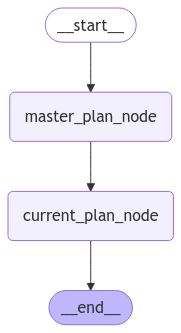

In [115]:
from IPython.display import Image, display

from langgraph.graph import StateGraph, START, END

builder = StateGraph(AgentState)

builder.add_node("master_plan_node", master_plan_node)
builder.add_node("current_plan_node", current_plan_node)

builder.add_edge(START, "master_plan_node")
builder.add_edge("master_plan_node", "current_plan_node")
builder.add_edge("current_plan_node", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [116]:
async def setup_browser(go_to_page: str):
    playwright = await async_playwright().start()
    browser = await playwright.chromium.launch(headless=False)
    page = await browser.new_page()
    await page.goto(go_to_page)
    return playwright, browser, page



async def call_agent(task: str, go_to_page: str, max_steps: int = 250):
    playwright, browser, page = await setup_browser(go_to_page)
    final_answer = None
    event_stream = graph.astream(
        {
            "task": task, 
            "page": page, 
            "last_tool_action": ""
        }, 
        {
            "recursion_limit": max_steps
        },
        stream_mode="values"
    )

    try:
        async for event in event_stream:
            print(event)
            if "current_plan" in event:
                final_answer = event["current_plan"]
                print("\nFinal Answer:", final_answer)
                break
            

    finally:
        await browser.close()
        await playwright.stop()
        return final_answer

task = "nvidia stock forecast"
go_to_page = "https://www.google.com/search?q=nvidia+stock+forecast&sca_esv=e974f7004088c941&sxsrf=ADLYWIIqomdj0zja8nQa8B7yM3K1IeXVzA%3A1736825827794&source=hp&ei=49uFZ_OmLsSHkdUPlauv-As&iflsig=AL9hbdgAAAAAZ4Xp87R2PNxoWsIHeyx8H7f2bUcJSFJi&oq=Nvidia+Stock&gs_lp=Egdnd3Mtd2l6IgxOdmlkaWEgU3RvY2sqAggDMhYQABiABBiRAhixAxiDARiKBRhGGPoBMgsQABiABBixAxiDATILEAAYgAQYsQMYgwEyCBAAGIAEGLEDMgsQABiABBixAxiDATIIEAAYgAQYsQMyCxAAGIAEGLEDGIMBMggQABiABBixAzILEAAYgAQYsQMYgwEyCBAAGIAEGLEDSL52UOQLWIxgcAV4AJABApgBwwWgAZorqgELMi04LjYuMC4xLjG4AQPIAQD4AQGYAhOgAucgqAIKwgIHECMYJxjqAsICChAjGIAEGCcYigXCAgsQABiABBiRAhiKBcICERAuGIAEGLEDGNEDGIMBGMcBwgIOEC4YgAQYsQMYgwEYigXCAgUQABiABMICBBAjGCfCAhEQLhiABBiRAhjRAxjHARiKBcICDhAuGIAEGLEDGNEDGMcBwgILEC4YgAQYsQMY5QTCAgsQABiABBixAxiKBcICCBAuGIAEGLEDwgILEC4YgAQY0QMYxwHCAg4QABiABBiRAhixAxiKBcICCxAuGIAEGMcBGK8BwgIREAAYgAQYkQIYsQMYgwEYigWYAwTxBZhueJjZtJr78QXFGUFj6GieZZIHBzUuMC44LjagB4WjAQ&sclient=gws-wiz"

final_answer = await call_agent(task, go_to_page)




{'messages': [], 'task': 'nvidia stock forecast', 'page': <Page url='https://www.google.com/search?q=nvidia+stock+forecast&sca_esv=e974f7004088c941&sxsrf=ADLYWIIqomdj0zja8nQa8B7yM3K1IeXVzA%3A1736825827794&source=hp&ei=49uFZ_OmLsSHkdUPlauv-As&iflsig=AL9hbdgAAAAAZ4Xp87R2PNxoWsIHeyx8H7f2bUcJSFJi&oq=Nvidia+Stock&gs_lp=Egdnd3Mtd2l6IgxOdmlkaWEgU3RvY2sqAggDMhYQABiABBiRAhixAxiDARiKBRhGGPoBMgsQABiABBixAxiDATILEAAYgAQYsQMYgwEyCBAAGIAEGLEDMgsQABiABBixAxiDATIIEAAYgAQYsQMyCxAAGIAEGLEDGIMBMggQABiABBixAzILEAAYgAQYsQMYgwEyCBAAGIAEGLEDSL52UOQLWIxgcAV4AJABApgBwwWgAZorqgELMi04LjYuMC4xLjG4AQPIAQD4AQGYAhOgAucgqAIKwgIHECMYJxjqAsICChAjGIAEGCcYigXCAgsQABiABBiRAhiKBcICERAuGIAEGLEDGNEDGIMBGMcBwgIOEC4YgAQYsQMYgwEYigXCAgUQABiABMICBBAjGCfCAhEQLhiABBiRAhjRAxjHARiKBcICDhAuGIAEGLEDGNEDGMcBwgILEC4YgAQYsQMY5QTCAgsQABiABBixAxiKBcICCBAuGIAEGLEDwgILEC4YgAQY0QMYxwHCAg4QABiABBiRAhixAxiKBcICCxAuGIAEGMcBGK8BwgIREAAYgAQYkQIYsQMYgwEYigWYAwTxBZhueJjZtJr78QXFGUFj6GieZZIHBzUuMC44LjagB4WjAQ&sclient=gws-wiz'>, 'last_tool_action': ''